In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dask.distributed import Client
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

Para executar tarefas distribuídas, precisamos conectar nosso notebook ao scheduler do Dask.  
O Client cria uma conexão com o cluster e permite monitorar os workers e tarefas através de um dashboard web.

In [3]:
client = Client("tcp://192.168.2.16:8786")
client.dashboard_link

c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distributed\client.py:1591: VersionMismatchWarning: Mismatched versions found

+-------------+----------+-----------+---------+
| Package     | Client   | Scheduler | Workers |
+-------------+----------+-----------+---------+
| dask        | 2025.9.1 | 2025.10.0 | None    |
| distributed | 2025.9.1 | 2025.10.0 | None    |
+-------------+----------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


'http://192.168.2.16:8787/status'

Criação de um dataset sintético usando o make_classification do dask-ml, com o objetivo de simular um grande conjunto de dados.


In [4]:
X, y = make_classification(
    n_samples=1_000_000,
    n_features=10,
    n_informative=5,
    n_classes=2,
    chunks=100_000,
    random_state=42
)

print(X.shape)
print(y.shape)

(1000000, 10)
(1000000,)


Visualização do Grafo de Tarefas Dask, como dividimos as chunks em um tamanho de 100_000 e possuimos 1_000_000, serão criadas 10 tarefas para executar cada partição dos dados

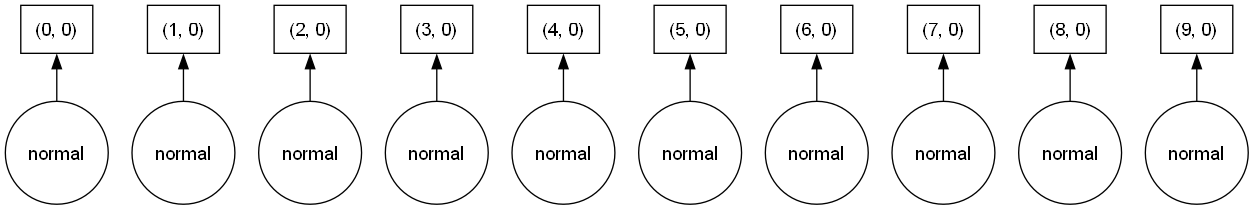

In [5]:
X.visualize()


Divisão dos dados em treino e teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Grafo que demonstra como Dask criou as tarefas para separar os dados sem copiar todos na memória.

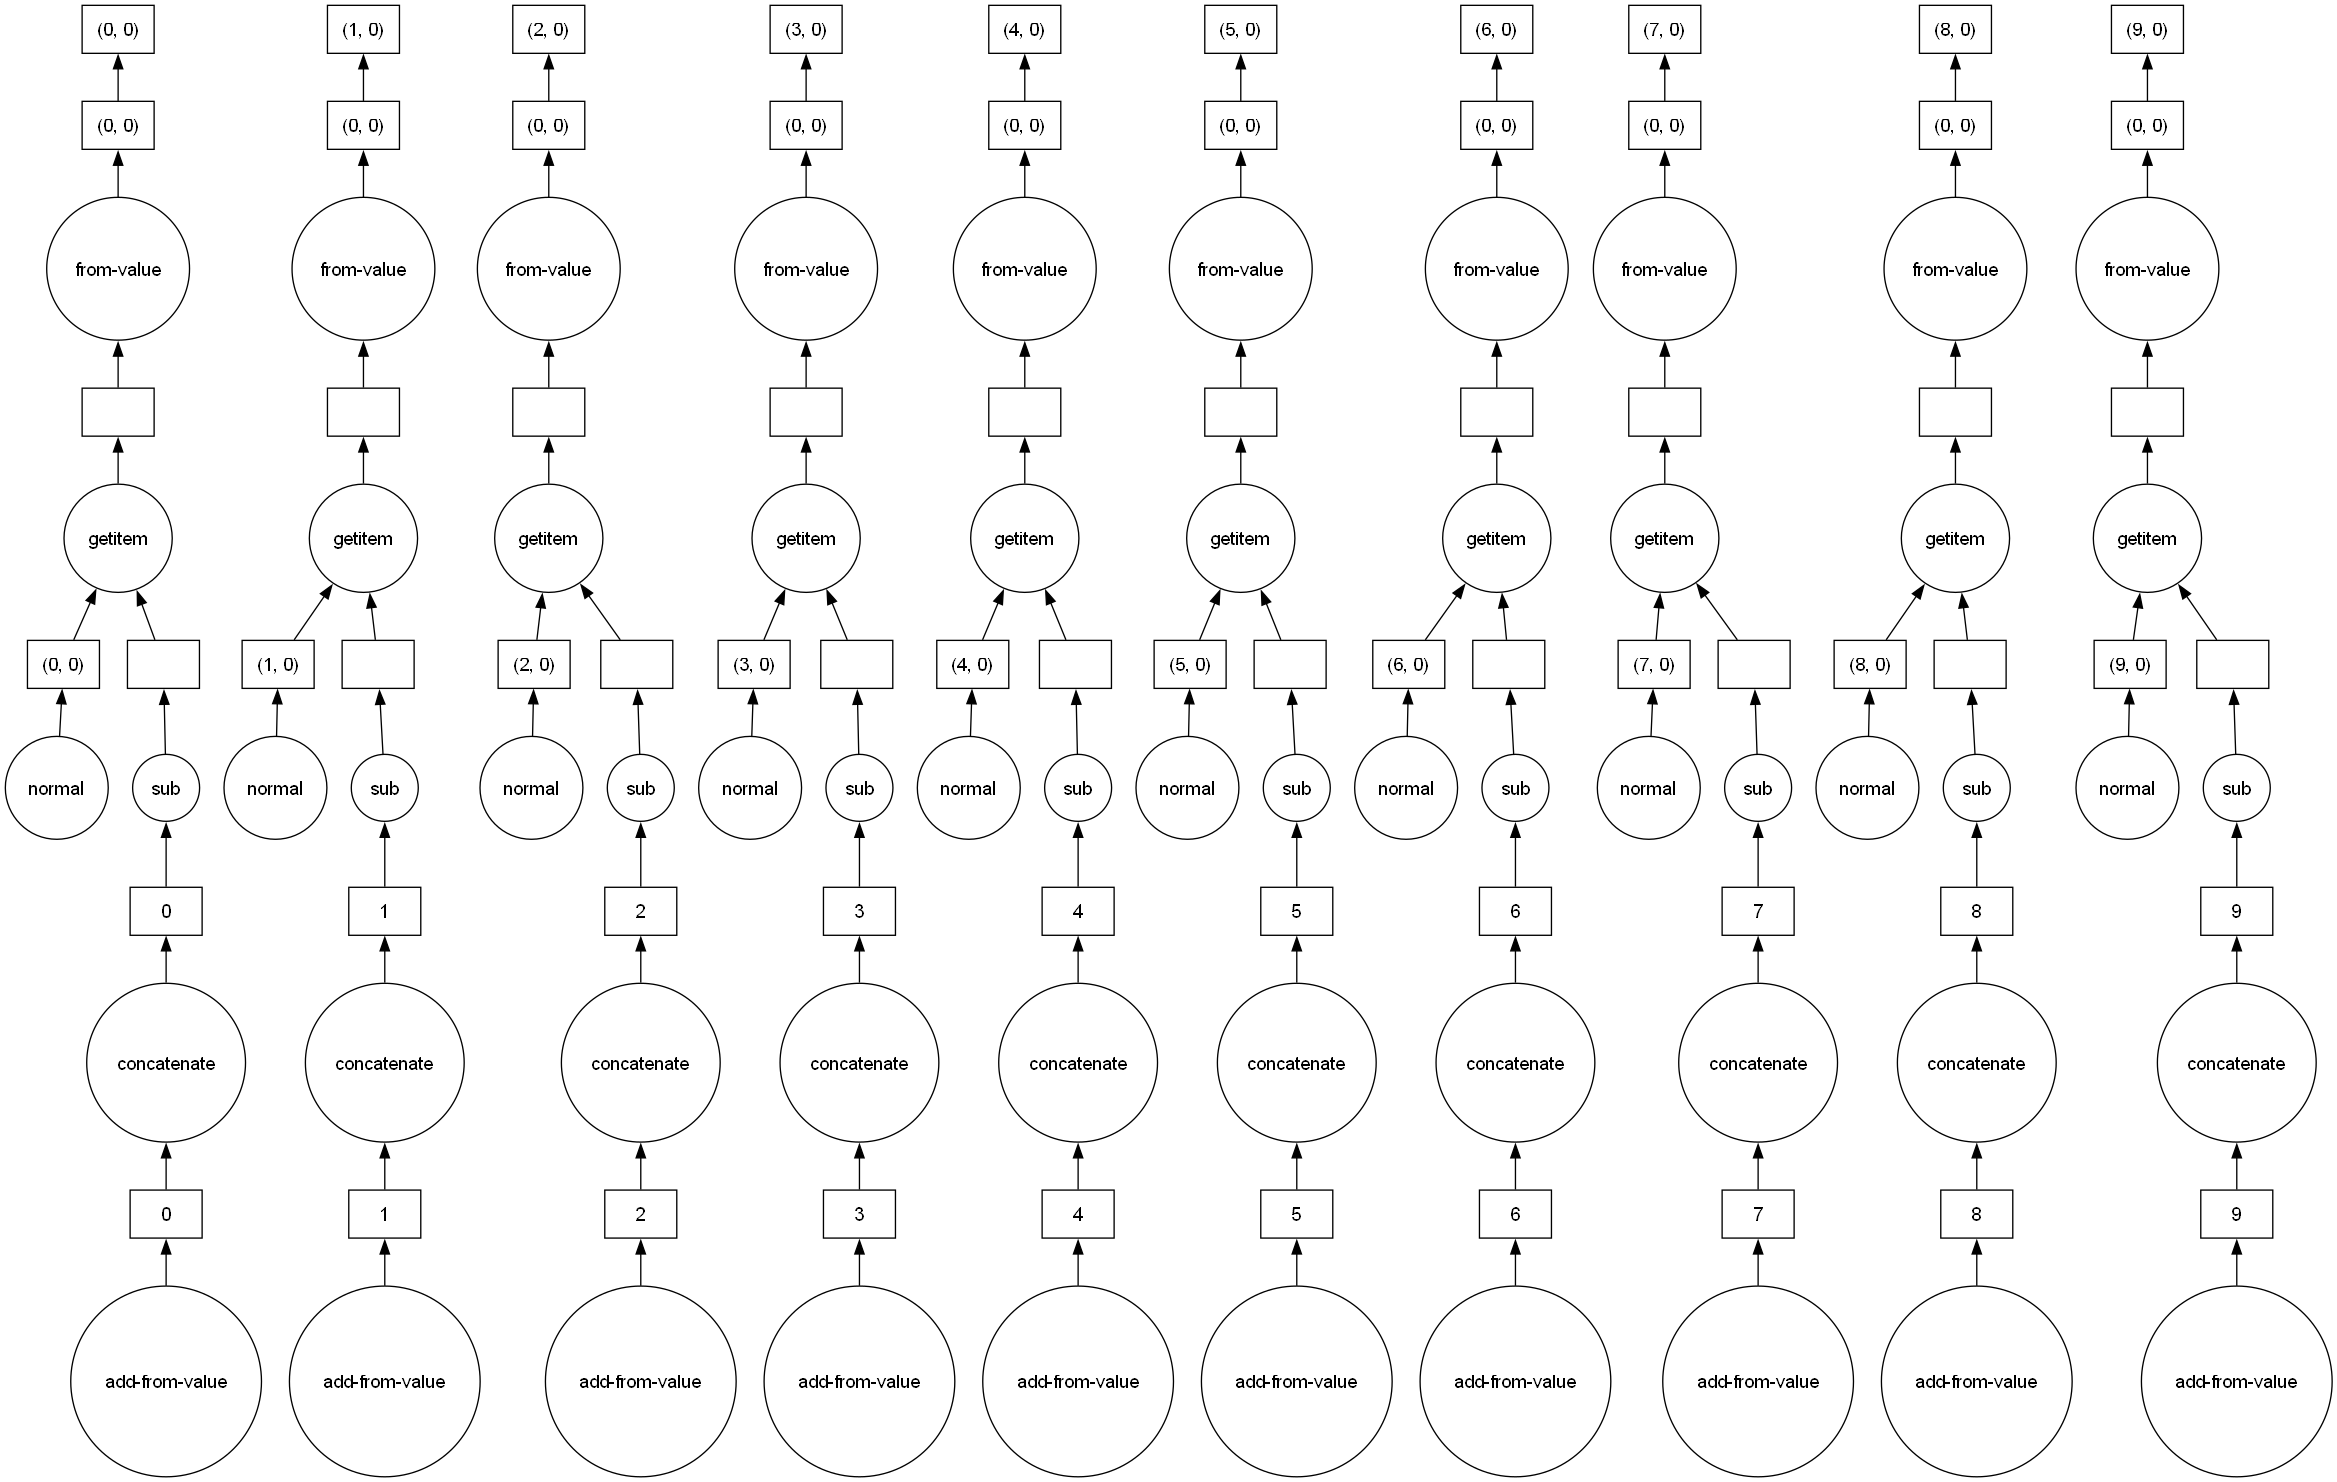

In [7]:
X_train.visualize()


Treinamento distribuído do modelo, como utilizamos o LogisticRegression existente no Dask de forma nativa, o modelo será treinado de forma distribuída sem a necessidade de código adicional de um treinamento convencional do sckit-learn

In [8]:
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1.0
,class_weight,None
,random_state,None
,solver,'admm'
,max_iter,100
,multi_class,'ovr'


Avaliação do modelo

In [ ]:
y_pred = model.predict(X_test)

y_test_pd = y_test.compute()
y_pred_pd = y_pred.compute()

report = classification_report(y_test_pd, y_pred_pd)

print(report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77    150118
           1       0.77      0.77      0.77    149882

    accuracy                           0.77    300000
   macro avg       0.77      0.77      0.77    300000
weighted avg       0.77      0.77      0.77    300000

CPU times: total: 234 ms
Wall time: 5.43 s


Grafo que demonstra como Dask distribuiu o cálculo das previsões entre os chunks do dataset e os workers.

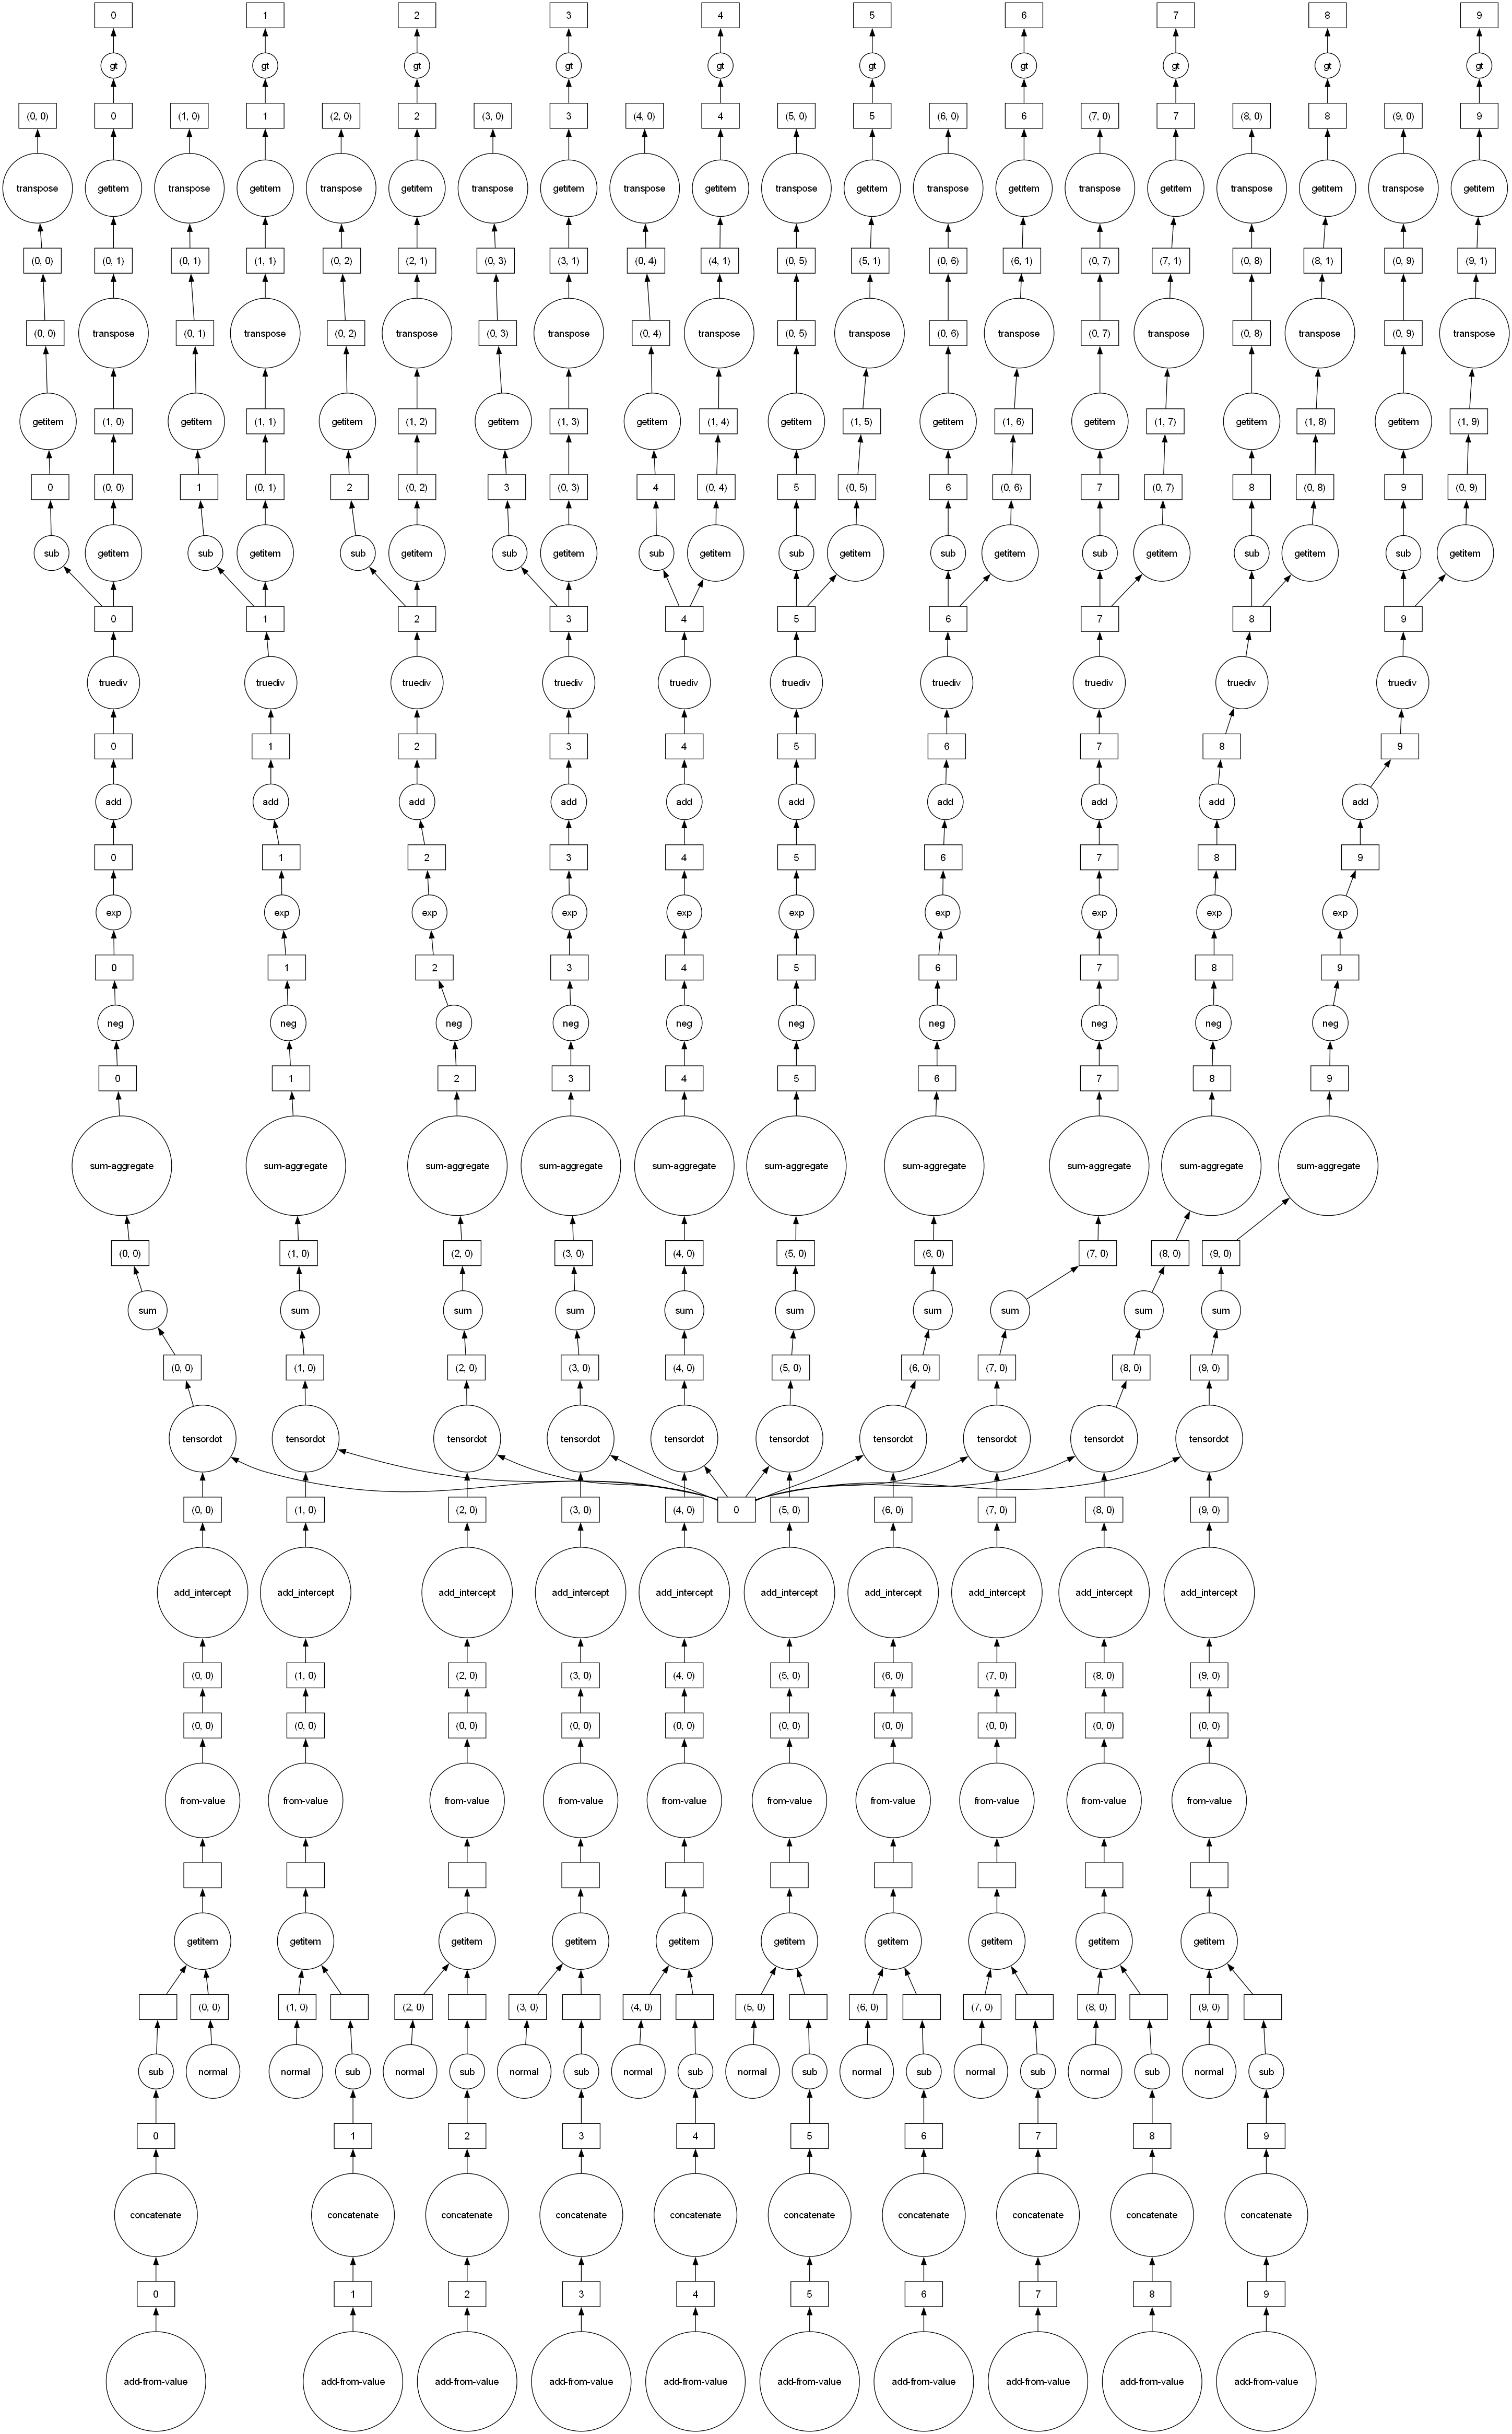

In [10]:
y_pred.visualize()

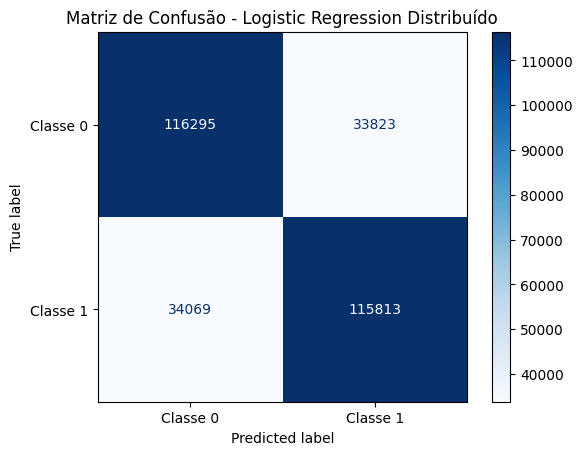

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_pd, y_pred_pd)
# Supondo que y_test_pd e y_pred_pd já estão prontos
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Classe 0", "Classe 1"])
cm_display.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' para inteiros
plt.title("Matriz de Confusão - Logistic Regression Distribuído")
plt.show()


In [12]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [13]:
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Convertendo os dados que estão no formato de array numpy para dask array, dividindo em 7 chunks de 10 mil linhas cada

In [ ]:
import dask.array as da

X_np = mnist.data.to_numpy()
y_np = mnist.target.to_numpy()

X = da.from_array(X_np, chunks=(10000, X_np.shape[1]))
y = da.from_array(y_np, chunks=(10000,))

print(X.shape, X.chunks)
print(y.shape, y.chunks)

(70000, 784) ((10000, 10000, 10000, 10000, 10000, 10000, 10000), (784,))
(70000,) ((10000, 10000, 10000, 10000, 10000, 10000, 10000),)


In [ ]:
y = y.astype(np.uint8)

In [16]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3)

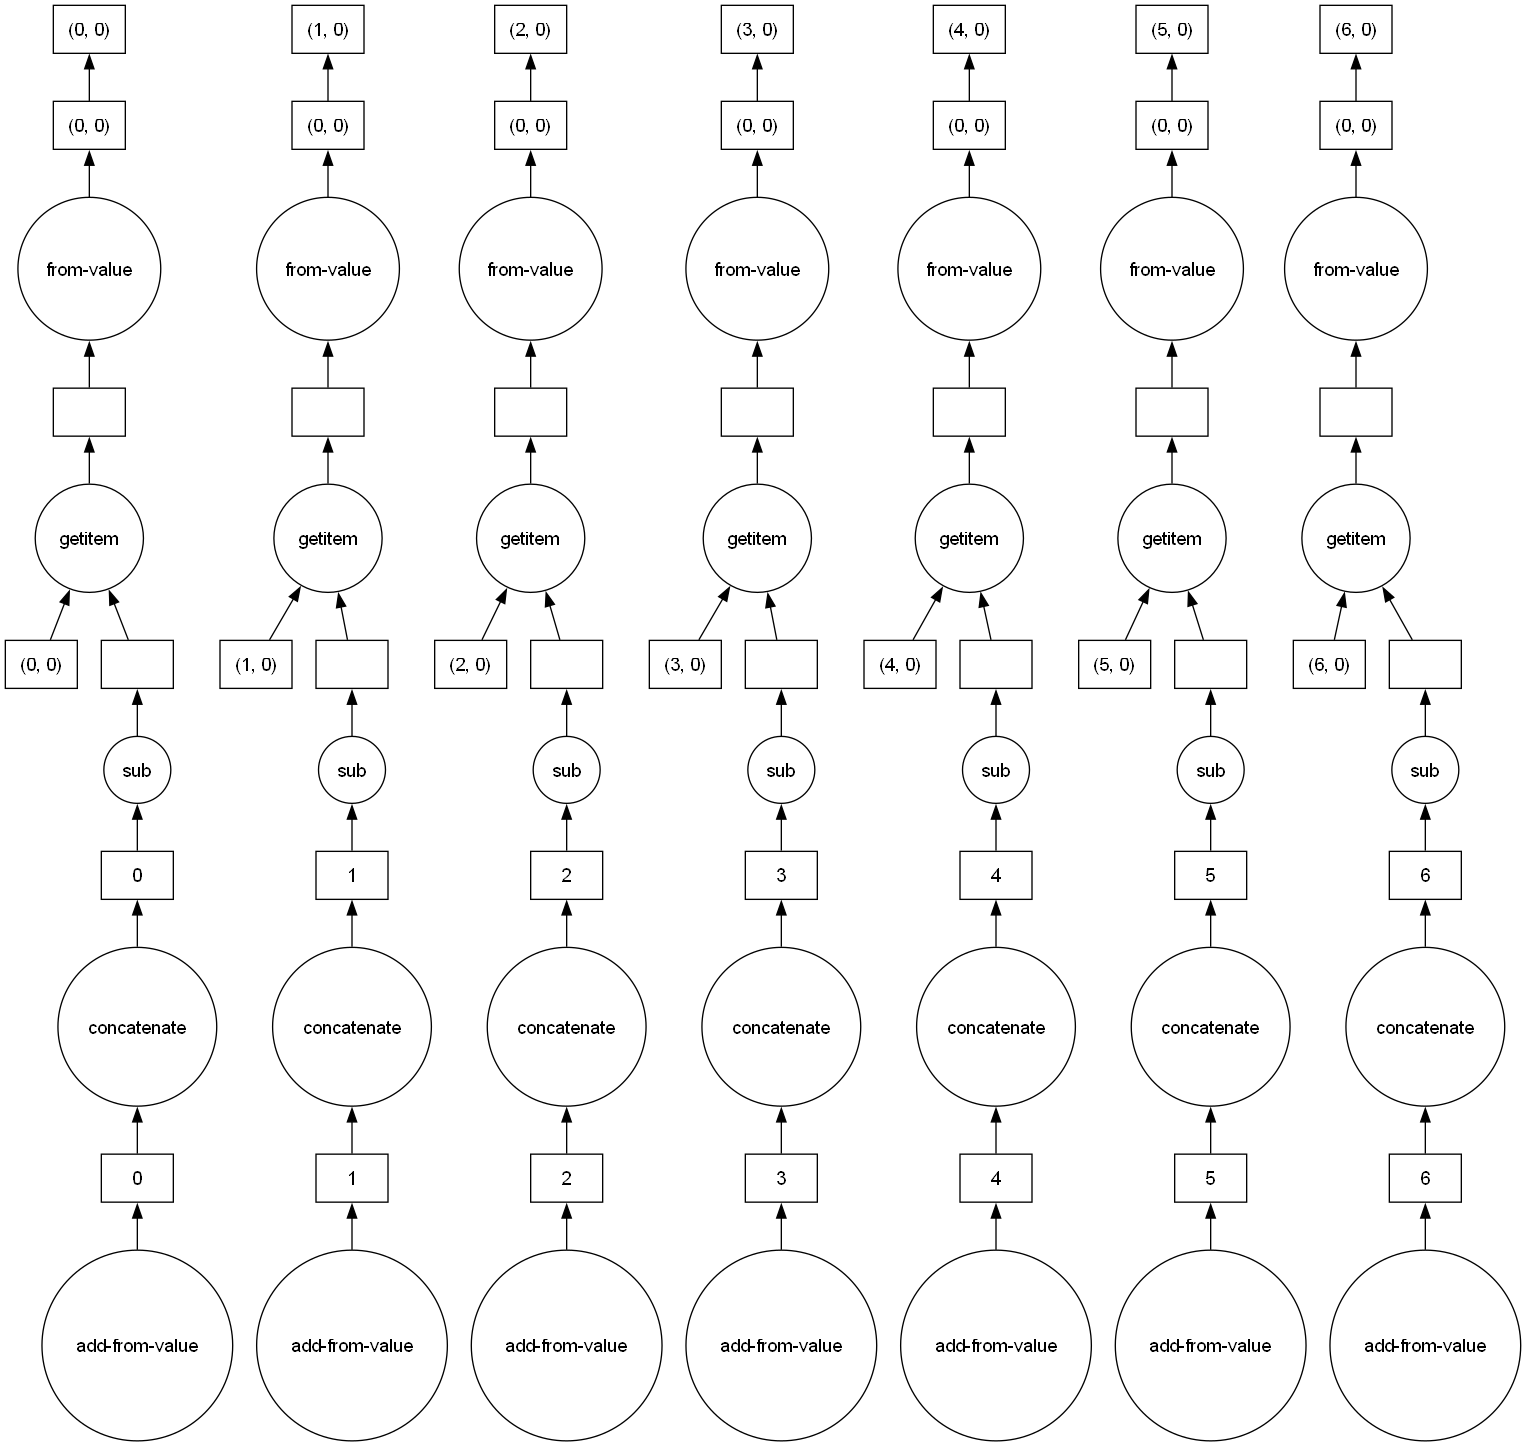

In [17]:
X_train.visualize()

O modelo RandomForestClassifier será utilizado para esta tarefa, como o Dask não possui mais o modelo RandomForestClassifier de forma nativa em sua mais nova atualização, é necessário utilizarmos o ParallelPostFit para distribuir o processamento entre os workers

In [18]:
from sklearn.ensemble import RandomForestClassifier
from dask_ml.wrappers import ParallelPostFit

random_forest = ParallelPostFit(RandomForestClassifier(random_state=42))

In [ ]:
%%time
random_forest.fit(X_train, y_train)

c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 418.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: total: 53.1 s
Wall time: 3min 51s


,estimator,RandomForestC...ndom_state=42)
,scoring,None
,predict_meta,None
,predict_proba_meta,None
,transform_meta,None
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [ ]:
%%time
random_forest.predict(X_test)

CPU times: total: 188 ms
Wall time: 285 ms


dask.array<_predict, shape=(21000,), dtype=uint8, chunksize=(3000,), chunktype=numpy.ndarray>

c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 535.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 535.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distrib

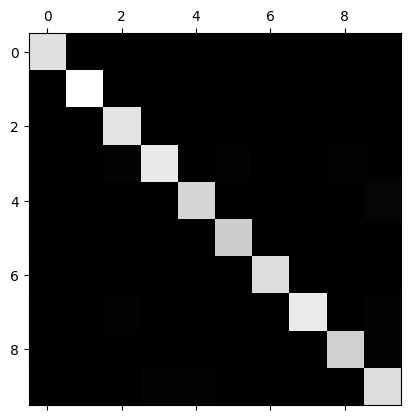

c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 535.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 535.22 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
c:\Users\vitin\Documents\TADS\Aprendizado_maquina\trabalho_dask\venv\Lib\site-packages\distrib

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2053
           1       0.98      0.99      0.99      2344
           2       0.96      0.97      0.96      2115
           3       0.97      0.95      0.96      2233
           4       0.97      0.96      0.97      2014
           5       0.97      0.96      0.97      1931
           6       0.98      0.98      0.98      2028
           7       0.97      0.96      0.97      2197
           8       0.95      0.95      0.95      1985
           9       0.94      0.95      0.95      2100

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000



In [22]:
yhat = random_forest.predict(X_test)
conf_mx = confusion_matrix(y_test, yhat)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

print(classification_report(y_test,yhat))